In [ ]:
"""
Weights Calculation for Weather Analogue Model
==============================================

This notebook calculates and visualizes different types of weights used in the weather analogue model:
1. Variable weights - importance of different atmospheric variables
2. Grid point weights - spatial importance across the region
3. Time weights - temporal importance based on lead time

The weights are derived using correlation analysis between variables and precipitation data.
"""

# Standard library imports
import copy
import datetime
import json
import math
import os
import random
import sys

# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import xarray as xr
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean, cosine
from tqdm import tqdm

# Geospatial libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Additional imports that might be used in later analysis
# These can be commented out if not needed
# PyTorch related imports
# import torch
# import torch.nn as nn
# from torch.nn import functional as F
# from torch.utils.data import Dataset, DataLoader, random_split, Subset

# # PyTorch Lightning related imports
# import pytorch_lightning as pl
# from pytorch_lightning import Trainer, seed_everything
# from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
# from pytorch_lightning.loggers import WandbLogger, Logger

# # Wandb (Weights & Biases) related imports
# import wandb

In [ ]:
def setup_environment():
    """
    Set up the project environment by configuring paths and importing project modules.
    
    Returns:
        str: Current working directory
    """
    try:
        # Navigate to project root directory
        os.chdir("../")
    except Exception as e:
        print(f"Error changing directory: {e}")
    
    # Get and print current working directory
    current_directory = os.getcwd()
    print(f"Current Directory: {current_directory}")
    
    # Add notebooks directory to path
    notebooks_path = os.path.abspath(os.path.join(current_directory, "notebooks"))
    if notebooks_path not in sys.path:
        sys.path.append(notebooks_path)
    
    return current_directory

def set_plot_style(size=14):
    """
    Configure consistent matplotlib plot style settings
    
    Args:
        size (int): Base font size for plots
    """
    matplotlib.rcParams.update({
        'font.size': size,         # Global font size
        'axes.titlesize': size+2,  # Title font size
        'axes.labelsize': size,    # Axis label font size
        'xtick.labelsize': size-2, # X-tick label font size
        'ytick.labelsize': size-2, # Y-tick label font size
        'legend.fontsize': size,   # Legend font size
    })

# Setup the environment
current_dir = setup_environment()

# Import project utilities
try:
    from utils.utils import load_json_config
    from utils.utils_data import read_netcdf, read_netcdf_raw
    print("Successfully imported project utilities")
except ImportError as e:
    print(f"Error importing project utilities: {e}")

# Apply consistent plotting style
set_plot_style()

Current Directory: /home/yuhan/Desktop/Master/yu-ml-weather-analogue


## Data Loading and Processing

Loading weather variables and precipitation data from preprocessed files, and extracting events data for analysis.

In [ ]:
def load_weather_data(variables, frequency, time_unit, method, preprocessing, year_range):
    """
    Load weather data based on specified parameters
    
    Args:
        variables (str): String identifying the variables (e.g., 'd2muvmslr')
        frequency (int): Temporal frequency
        time_unit (str): Time unit ('h' for hours, 'd' for days)
        method (str): Resampling method
        preprocessing (str): Preprocessing method
        year_range (tuple): Tuple of (start_year, end_year)
        
    Returns:
        xarray.Dataset: Loaded weather data
    """
    # Construct file path
    file_path = f"data/processed/{variables}_{frequency}{time_unit}_{method}_{preprocessing}_{year_range[0]}{year_range[1]}.h5"
    print(f"Loading data from: {file_path}")
    
    # Load the data
    try:
        data = read_netcdf_raw(file_path)
        print(f"Data loaded successfully with shape: {data.dims}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def load_events_data(events_file_path):
    """
    Load events data from a CSV file and process timestamps
    
    Args:
        events_file_path (str): Path to the events CSV file
        
    Returns:
        pandas.DataFrame: Processed events data
    """
    try:
        events_df = pd.read_csv(events_file_path)
        events_df = events_df.sort_values(by="start datetime")  # Sort by start datetime
        
        # Convert string timestamps to datetime objects
        events_df["start datetime"] = pd.to_datetime(events_df["start datetime"])
        events_df["end datetime"] = pd.to_datetime(events_df["end datetime"])
        
        print(f"Loaded {len(events_df)} events from {events_file_path}")
        return events_df
    except Exception as e:
        print(f"Error loading events data: {e}")
        return None

def get_events_data(ds, events_df):
    """
    Extract data for specific event time periods from a dataset
    
    Args:
        ds (xarray.Dataset): The full weather dataset
        events_df (pandas.DataFrame): DataFrame containing event time periods
        
    Returns:
        list: List of xarray.Dataset objects, one for each event
    """
    event_data_arrays = []
    for _, row in events_df.iterrows():
        start_time = pd.to_datetime(row["start datetime"])
        end_time = pd.to_datetime(row["end datetime"])
        # Filter data for each event time period
        filtered_data = ds.sel(time=slice(start_time, end_time))
        event_data_arrays.append(filtered_data)
    
    print(f"Extracted data for {len(event_data_arrays)} events")
    return event_data_arrays

# Define data parameters
variables = "d2muvmslr"
variable_list = ["d2m", "u", "v", "msl", "r"]
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Load atmospheric variables data
all_variables_data = load_weather_data(
    variables=variables,
    frequency=selected_frequency,
    time_unit=time_unit,
    method=resample_method,
    preprocessing=preprocessing_method,
    year_range=year_range
)

# Load precipitation data
prep_data = load_weather_data(
    variables="tp",
    frequency=selected_frequency,
    time_unit=time_unit,
    method=resample_method,
    preprocessing=preprocessing_method,
    year_range=year_range
)

# Calculate standard deviations of variables
std_devs = all_variables_data.std(dim=['time', 'y', 'x'])
std_devs_list = std_devs["__xarray_dataarray_variable__"].values.tolist()
print(f"Standard deviations of variables: {std_devs_list}")

# Load events data
events_df = load_events_data("notebooks/dataset/events_flood.csv")
print(f"First few events:\n{events_df.head()}")

# Extract data for events
variables_events = get_events_data(all_variables_data, events_df)
prep_events = get_events_data(prep_data, events_df)

# Combine all events data
all_variables_events = xr.concat(variables_events, dim='time')
all_prep_events = xr.concat(prep_events, dim='time')
print(f"Combined events data shape - Variables: {all_variables_events.dims}, Precipitation: {all_prep_events.dims}")

## Weight Calculation Functions

These functions handle weight calculations and visualizations for the analogue model.

In [ ]:
def plot_bar_chart(data, labels=None, show_values=True, title=None, xlabel=None, ylabel=None, figsize=(5, 4)):
    """
    Create a bar chart visualization for weights or other numerical data
    
    Args:
        data (list): Data values to plot
        labels (list, optional): Labels for x-axis
        show_values (bool): Whether to show data values above bars
        title (str, optional): Chart title
        xlabel (str, optional): X-axis label
        ylabel (str, optional): Y-axis label
        figsize (tuple): Figure size in inches
        
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')
    positions = range(len(data))
    bars = ax.bar(positions, data, color="skyblue")

    # Set x-axis labels if provided
    if labels is not None:
        if len(labels) != len(data):
            raise ValueError("Labels count doesn't match data count")
        ax.set_xticks(positions)
        ax.set_xticklabels(labels)

    # Set title and axis labels if provided
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    # Add value annotations on bars
    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                "{:.4f}".format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    plt.tight_layout()
    return fig

def normalize_weights(values):
    """
    Normalize weights based on absolute values
    
    Args:
        values (numpy.ndarray): Raw weight values
        
    Returns:
        numpy.ndarray: Normalized weights
    """
    abs_values = np.abs(values)  # Get absolute values
    sum_abs_values = np.sum(abs_values)  # Calculate sum of absolute values
    normalized_weights = abs_values / sum_abs_values  # Normalize
    
    return normalized_weights

def compute_correlation(da, ref_series):
    """
    Compute correlation between a data array and a reference series
    
    Args:
        da (xarray.DataArray): The data array
        ref_series (xarray.DataArray): The reference series
    
    Returns:
        xarray.DataArray: Correlation values
    """
    # Align the data
    aligned_ref, aligned_da = xr.align(ref_series, da, join='inner', copy=False)
    
    # Compute the means
    demeaned_da = aligned_da - aligned_da.mean(dim='time')
    demeaned_ref = aligned_ref - aligned_ref.mean(dim='time')
    
    # Compute covariance
    covariance = (demeaned_da * demeaned_ref).mean(dim='time')
    
    # Compute standard deviations
    std_da = aligned_da.std(dim='time')
    std_ref = aligned_ref.std(dim='time')
    
    # Compute correlation
    correlation = covariance / (std_da * std_ref)
    
    return correlation

def generate_time_weights(time_window, leadtime, reverse=True):
    """
    Generate normalized time weights
    
    Args:
        time_window (int): Number of time steps to consider
        leadtime (int): Lead time for prediction
        reverse (bool): Whether to reverse weights (higher for smaller time differences)
    
    Returns:
        list: Normalized time weights
    """
    # Generate weights based on time difference
    weights = list(range(leadtime, leadtime + time_window))
    
    # Optionally reverse weights so that smaller time differences get higher weights
    if reverse:
        weights.reverse()
    
    # Normalize weights
    total = sum(weights)
    normalized_weights = [w / total for w in weights]
    
    return normalized_weights

def plot_horizontal_bar(series, figsize=(5, 4), title=None, xlabel=None, save_path=None):
    """
    Create a horizontal bar chart for a pandas Series
    
    Args:
        series (pandas.Series): Data series to plot
        figsize (tuple): Figure size in inches
        title (str, optional): Chart title
        xlabel (str, optional): X-axis label
        save_path (str, optional): Path to save the figure
        
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')
    
    # Create horizontal bars
    bars = ax.barh(series.index, series.values, color='skyblue')
    
    # Calculate threshold for text placement
    threshold_width = ax.get_xlim()[1] * 0.9
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        if width > threshold_width:  # If bar is too wide, place text inside
            label_x_pos = width - 0.05
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                   f'{width:.4f}', va='center', ha='right', color='white')
        else:  # Otherwise place text outside
            label_x_pos = width + 0.01
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                   f'{width:.4f}', va='center')
    
    # Set title and labels
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, transparent=True)
    
    return fig

## 1. Variable Weights Calculation

Calculating the importance weights for each atmospheric variable based on their correlation with precipitation.

channel         0         1         2         3         4
channel                                                  
0        1.000000 -0.066448  0.096358  0.312741  0.090297
1       -0.066448  1.000000  0.290119 -0.334597 -0.174957
2        0.096358  0.290119  1.000000 -0.348398  0.040774
3        0.312741 -0.334597 -0.348398  1.000000 -0.073438
4        0.090297 -0.174957  0.040774 -0.073438  1.000000 channel         0         0         1         2         3         4
channel                                                            
0        1.000000  0.046042 -0.176905  0.021893 -0.104954  0.325786
0        0.046042  1.000000 -0.066448  0.096358  0.312741  0.090297
1       -0.176905 -0.066448  1.000000  0.290119 -0.334597 -0.174957
2        0.021893  0.096358  0.290119  1.000000 -0.348398  0.040774
3       -0.104954  0.312741 -0.334597 -0.348398  1.000000 -0.073438
4        0.325786  0.090297 -0.174957  0.040774 -0.073438  1.000000


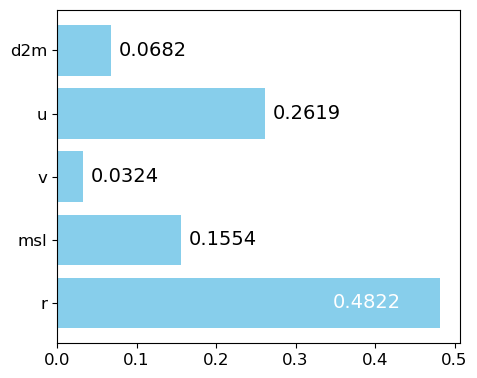

In [ ]:
# Define reference point for analysis
ref_x_position = 16  # Reference x coordinate
ref_y_position = 14  # Reference y coordinate

def calculate_variable_weights(variables_data, precipitation_data, x_pos, y_pos, variable_list):
    """
    Calculate variable weights based on correlation with precipitation at a specific location
    
    Args:
        variables_data (xarray.Dataset): Dataset containing atmospheric variables
        precipitation_data (xarray.Dataset): Dataset containing precipitation data
        x_pos (int): X coordinate of the reference point
        y_pos (int): Y coordinate of the reference point
        variable_list (list): List of variable names
    
    Returns:
        pandas.Series: Normalized variable weights
    """
    print(f"Calculating variable weights for reference point ({x_pos}, {y_pos})")
    
    # Extract data at the specific location
    variables_at_location = variables_data.isel(x=x_pos, y=y_pos)
    precipitation_at_location = precipitation_data.isel(x=x_pos, y=y_pos)
    
    # Convert to dataframes
    var_df = variables_at_location.to_dataframe()
    prep_df = precipitation_at_location.to_dataframe()
    
    # Unstack channel dimension to get separate columns for each variable
    var_df = var_df.unstack('channel')['__xarray_dataarray_variable__']
    prep_df = prep_df.unstack('channel')['__xarray_dataarray_variable__']
    
    # Rename columns with variable names
    var_df.columns = variable_list
    
    # Standardize the data
    scaler = StandardScaler()
    var_df_scaled = pd.DataFrame(
        scaler.fit_transform(var_df), 
        index=var_df.index, 
        columns=variable_list
    )
    
    prep_df_scaled = pd.DataFrame(
        scaler.fit_transform(prep_df), 
        index=prep_df.index, 
        columns=['precipitation']
    )
    
    # Combine for correlation analysis
    combined_df_scaled = pd.concat([prep_df_scaled, var_df_scaled], axis=1)
    
    # Calculate correlation matrix
    correlation_matrix = combined_df_scaled.corr()
    
    # Extract correlation with precipitation
    correlation_with_precipitation = correlation_matrix['precipitation'][1:]  # Exclude precipitation's self-correlation
    
    # Normalize weights
    total_abs = correlation_with_precipitation.abs().sum()
    variable_weights = correlation_with_precipitation.abs() / total_abs
    
    print("Variable correlations with precipitation:")
    for var, corr in correlation_with_precipitation.items():
        print(f"  {var}: {corr:.4f}")
    
    print("\nNormalized variable weights:")
    for var, weight in variable_weights.items():
        print(f"  {var}: {weight:.4f}")
    
    return variable_weights

# Calculate variable weights
variable_weights = calculate_variable_weights(
    all_variables_events, 
    all_prep_events,
    ref_x_position, 
    ref_y_position,
    variable_list
)

# Reverse order for visualization (bottom-to-top)
reversed_variable_weights = variable_weights.iloc[::-1]

# Create horizontal bar chart
fig = plot_horizontal_bar(
    reversed_variable_weights,
    figsize=(5, 4),
    xlabel='Normalized Coefficient',
    save_path='3_3_var_weights.png'
)

plt.show()

## 2. Grid Point Weights Calculation

Calculating the spatial importance of different grid points based on their correlation with precipitation at the reference point.

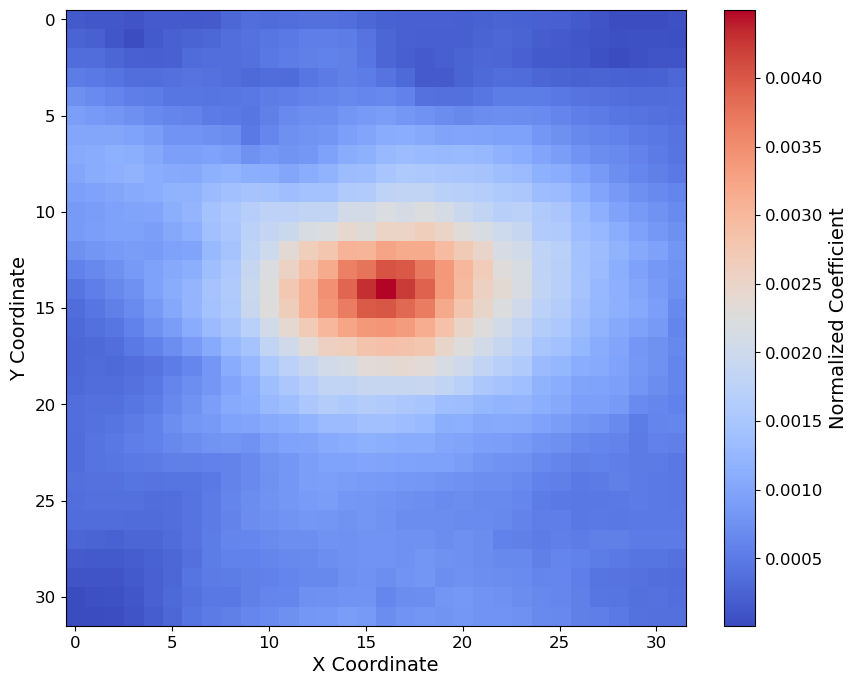

In [ ]:
def calculate_grid_weights(data, ref_x, ref_y):
    """
    Calculate grid weights based on correlation with a reference point
    
    Args:
        data (xarray.Dataset): Dataset containing the variable
        ref_x (int): X coordinate of reference point
        ref_y (int): Y coordinate of reference point
    
    Returns:
        xarray.DataArray: Normalized grid weights
    """
    # Get reference series at the specified location
    ref_series = data['__xarray_dataarray_variable__'].isel(x=ref_x, y=ref_y)
    
    # Compute correlation between each grid point and the reference point
    correlation = compute_correlation(data['__xarray_dataarray_variable__'], ref_series)
    
    # Normalize correlations to get weights
    normalized_correlation = normalize_weights(correlation)
    
    return normalized_correlation

# Reference point coordinates (same as used for variable weights)
ref_x = 16
ref_y = 14

# Calculate grid weights based on precipitation correlation
grid_weights = calculate_grid_weights(all_prep_events, ref_x, ref_y)

# Visualize as a simple heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.imshow(grid_weights[0], cmap='coolwarm', origin='upper', aspect='auto')
plt.colorbar(heatmap, label='Normalized Coefficient')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Grid Weights')
plt.show()

# Create a cartographic visualization
def plot_grid_weights_map(grid_weights, figsize=(6, 6), save_path=None):
    """
    Plot grid weights on a map with geographic features
    
    Args:
        grid_weights (xarray.DataArray): The grid weights
        figsize (tuple): Figure size in inches
        save_path (str, optional): Path to save the figure
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()}, facecolor='none')
    
    # Set map extent for UK
    ax.set_extent([-6, 2, 48, 56])
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    
    # Create grid coordinates
    lons = np.arange(-6, 2.25, 0.25)  # longitude range
    lats = np.arange(56, 47.75, -0.25)  # latitude range, reversed to match grid orientation
    lons, lats = np.meshgrid(lons, lats)
    
    # Plot weights as a colored mesh
    heatmap = ax.pcolormesh(
        lons, lats, grid_weights[0], 
        cmap='coolwarm', 
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(heatmap, ax=ax, shrink=0.8, label='Normalized Coefficient')
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, transparent=True)
    
    return fig

# Plot grid weights on a map
grid_map = plot_grid_weights_map(grid_weights, save_path='3_3_grid_weights.png')
plt.show()

# Find grid points with coefficients above a threshold
def highlight_important_grid_points(grid_weights, threshold=0.0030, figsize=(6, 6), save_path=None):
    """
    Highlight grid points with weights above a threshold on a map
    
    Args:
        grid_weights (xarray.DataArray): The grid weights
        threshold (float): Weight threshold for highlighting
        figsize (tuple): Figure size in inches
        save_path (str, optional): Path to save the figure
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": ccrs.PlateCarree()}, facecolor='none')
    
    # Set map extent for UK
    ax.set_extent([-6, 2, 48, 56])
    
    # Add geographic features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    
    # Create grid coordinates
    lons = np.arange(-6, 2.25, 0.25)
    lats = np.arange(56, 47.75, -0.25)
    lons, lats = np.meshgrid(lons, lats)
    
    # Find points above threshold
    indices = np.where(grid_weights[0] > threshold)
    scatter_lons = lons[indices]
    scatter_lats = lats[indices]
    
    # Count points above threshold
    num_points = len(scatter_lons)
    
    # Plot points
    ax.scatter(
        scatter_lons, scatter_lats, 
        color='red', s=20, 
        transform=ccrs.PlateCarree(), 
        label=f'Coeff > {threshold} (Points: {num_points})'
    )
    
    # Add legend
    ax.legend()
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, transparent=True)
    
    return fig, num_points

# Highlight important grid points
threshold = 0.0030
points_map, num_points = highlight_important_grid_points(
    grid_weights, 
    threshold=threshold,
    save_path='grid_points_above_threshold.png'
)
print(f"Found {num_points} grid points with weights above {threshold}")
plt.show()

## 3. Time Weights Calculation

Calculating the temporal weights based on time difference from the event, with higher weights for time points closer to the event.

[0.07142857142857142, 0.09523809523809523, 0.11904761904761904, 0.14285714285714285, 0.16666666666666666, 0.19047619047619047, 0.21428571428571427]


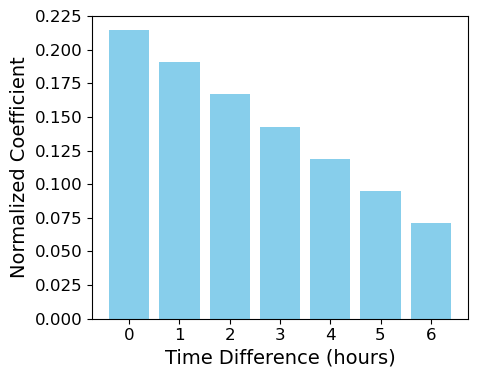

In [ ]:
def plot_time_weights(weights, positions=None, figsize=(5, 4), 
                      xlabel="Time Difference (hours)", ylabel="Normalized Coefficient",
                      show_values=True, save_path=None):
    """
    Plot time weights as a bar chart
    
    Args:
        weights (list): Time weights to plot
        positions (list, optional): X-axis positions for bars
        figsize (tuple): Figure size in inches
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        show_values (bool): Whether to show values above bars
        save_path (str, optional): Path to save the figure
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    fig, ax = plt.subplots(figsize=figsize, facecolor='none')
    
    # Use provided positions or create default ones
    if positions is None:
        positions = range(len(weights))
    
    # Create bars
    bars = ax.bar(positions, weights, color="skyblue")
    
    # Set axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Show values on bars if requested
    if show_values:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                "{:.4f}".format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )
    
    plt.tight_layout()
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, transparent=True)
    
    return fig

# 1. Simple linear time weights (decreasing with time difference)
def generate_linear_time_weights(time_window, leadtime):
    """
    Generate linear time weights (higher weights for smaller time differences)
    
    Args:
        time_window (int): Length of time window to consider
        leadtime (int): Lead time before the event
    
    Returns:
        list: Normalized time weights
    """
    # Generate weights starting from leadtime (larger numbers = later times)
    weights = list(range(leadtime, leadtime + time_window))
    
    # Reverse to give higher weights to smaller time differences
    weights.reverse()
    
    # Normalize
    total = sum(weights)
    normalized_weights = [w / total for w in weights]
    
    return normalized_weights

# Configure time window parameters
time_window = 7  # Number of time steps to consider
leadtime = 3     # Lead time before the event

# Generate and display time weights
time_weights = generate_linear_time_weights(time_window, leadtime)
print(f"Time weights (higher for times closer to event): {time_weights}")

# Visualize time weights
# Create positions that count down to event (e.g., 6, 5, 4, 3, 2, 1, 0 hours before event)
positions = list(range(time_window))[::-1]  # Reversed to count down

# Plot with custom positions
time_weights_plot = plot_time_weights(
    time_weights, 
    positions=positions,
    save_path='3_3_time_weights.png'
)
plt.show()

## Summary and Export of Weights

This notebook has calculated three types of weights for the weather analogue model:

1. **Variable Weights**: Importance of different atmospheric variables in relation to precipitation
2. **Grid Weights**: Spatial importance of different grid points across the UK region
3. **Time Weights**: Temporal importance based on time difference from the event

These weights can be used to create a more accurate and physically meaningful weather analogue model by prioritizing the most relevant aspects of the atmosphere when finding similar weather patterns.

In [13]:
def export_weights(variable_weights, grid_weights, time_weights, output_path='weights.json'):
    """
    Export all calculated weights to a JSON file
    
    Args:
        variable_weights (pandas.Series): Variable importance weights
        grid_weights (xarray.DataArray): Spatial grid importance weights
        time_weights (list): Temporal importance weights
        output_path (str): Path to save the JSON file
    """
    # Prepare weights data structure
    weights_data = {
        "variable_weights": variable_weights.tolist(),
        "grid_weights": grid_weights[0].values.tolist(),
        "time_weights": time_weights
    }
    
    # Save to JSON file
    with open(output_path, 'w') as f:
        json.dump(weights_data, f, indent=2)
    
    print(f"Weights successfully exported to {output_path}")
    
    # Print summary of weights
    print("\nWeights Summary:")
    print(f"  Variable weights: {len(variable_weights)} variables")
    print(f"  Grid weights: {grid_weights[0].shape[0]}×{grid_weights[0].shape[1]} grid")
    print(f"  Time weights: {len(time_weights)} time steps")
    
    return weights_data

# Export all weights to JSON
weights_data = export_weights(variable_weights, grid_weights, time_weights)

# Display sample of each weight type
print("\nVariable weights (sample):")
print(variable_weights)

print("\nGrid weights shape:")
print(grid_weights[0].shape)

print("\nTime weights:")
print(time_weights)